In [72]:
import ee
from scipy.signal import savgol_filter
from src.controllers.time_series import TimeSeries
from src.controllers.plotter_base import PhenologyPlotter
from src.controllers.metrics_vos_pos import VosPosMetrics
from src.controllers.metrics_bos_eso import BosEosMetrics
from src.controllers.geometry import ProcessadorGeoDataFrame

In [71]:
# Conecta ao Google Earth Engine
ee.Authenticate()
ee.Initialize()

In [88]:
# Datas de análise
start_date = '2022-10-01'
end_date = '2023-04-30'

#Paht polygons
path = r'data\sample_world.gpkg'

#Index polygon, defoult is 0
index_poligon = 1


# Aplicar o filtro Savitzky-Golay
window_size = 30
poly_order = 4

#Order NDVI
order = 30

In [89]:
#Read geometry file
processador = ProcessadorGeoDataFrame(path)
vertices, geometry = processador.extrair_coordenadas(index_poligon)

#Index time series
tm = TimeSeries(vertices, start_date, end_date)
df_index = tm.time_series_s2_ls()

#Smooth time series the index
df_index['savitzky_golay'] = savgol_filter(df_index ['NDVI'], window_size, poly_order)

#Get and VOS and POS metrics
vos_pos_analyzer = VosPosMetrics(df_index , order)
phenology_df = vos_pos_analyzer.analyze_phenology()

#Get and BOS and EOS metrics
analysis = BosEosMetrics(df_index , phenology_df, 0.457)
phenology_df  = analysis.execute_analysis()



EEException: A mapped function's arguments cannot be used in client-side operations

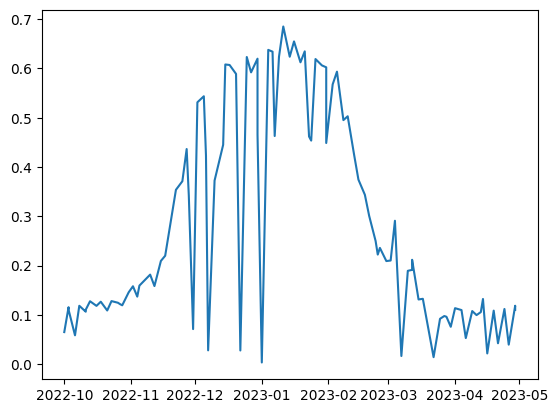

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_index['time'], df_index['NDVI'])

In [ ]:
df_index

,time,NDVI,EVI,SATELLITE,image_id,savitzky_golay
0,2022-10-01,0.065072,2.136246,Sentinel-2,20221001T140721_20221001T141917_T20HMG,0.069924
1,2022-10-03,0.115583,2.937694,Sentinel-2,20221003T135659_20221003T140552_T20HMG,0.087372
95,2022-10-03,0.110414,2.998660,Landsat9,2_LC09_228084_20221003,0.099881
2,2022-10-06,0.058556,4.147636,Sentinel-2,20221006T140709_20221006T142105_T20HMG,0.108322
3,2022-10-08,0.118471,2.913966,Sentinel-2,20221008T135711_20221008T141212_T20HMG,0.113510
...,...,...,...,...,...,...
80,2023-04-21,0.042452,2.060153,Sentinel-2,20230421T135709_20230421T140527_T20HMG,0.088377
81,2023-04-24,0.111954,2.949205,Sentinel-2,20230424T140709_20230424T141929_T20HMG,0.090104
82,2023-04-26,0.039652,2.286633,Sentinel-2,20230426T135701_20230426T140422_T20HMG,0.091806
83,2023-04-29,0.118537,2.840687,Sentinel-2,20230429T140711_20230429T141745_T20HMG,0.093362


In [ ]:
#Plot the results
visualizer = PhenologyPlotter(df_index , phenology_df)
visualizer.convert_dates()
fig = visualizer.plot_data()

fig

In [125]:
import ee
import pandas as pd

class Sentinel2:
    def __init__(self, polygon, start_date, end_date):
        self.polygon = ee.Geometry.Polygon(polygon)
        self.start_date = start_date
        self.end_date = end_date
        self.polygon_area = ee.Number(self.polygon.area())

    @staticmethod
    def add_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    @staticmethod
    def add_evi(image):
        evi = image.expression(
            '2.5 * (((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE)) + 1)',
            {
                'NIR': image.select('B8'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }
        ).rename('EVI')
        return image.addBands(evi)

    @staticmethod
    def mask_clouds(image):
        qa = image.select('QA60')
        cloud_bit_mask = ee.Number(2).pow(10).int()
        cirrus_bit_mask = ee.Number(2).pow(11).int()
        mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
            qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        return image.updateMask(mask)

    def extract_values(self):
        collection = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterDate(self.start_date, self.end_date) \
            .filterBounds(self.polygon) \
            .map(self.mask_clouds) \
            .map(self.add_ndvi) \
            .map(self.add_evi)\
            #.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',40))\

        def extract(image):
            stats = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=self.polygon,
                scale=30,
                maxPixels=1e9
            )
            ndvi = stats.get('NDVI')
            evi = stats.get('EVI')
            time = image.get('system:time_start')
            image_id = image.get('system:index')

            # Create a mask for cloud-free pixels
            cloud_mask = image.select('QA60').bitwiseAnd(1 << 10).eq(0).And(
                image.select('QA60').bitwiseAnd(1 << 11).eq(0)
            )
            cloud_free_image = image.updateMask(cloud_mask)
            
            cloud_free_area = cloud_free_image.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=self.polygon,
                scale=30,
                maxPixels=1e9
            ).get('B8')  # Using B8 just to get the pixel count
            
            cloud_free_area = ee.Number(cloud_free_area).multiply(900)  # Convert pixel count to area (30m * 30m per pixel)

            return ee.Feature(None, {
                'time': ee.Date(time).format('YYYY-MM-dd'),
                'NDVI': ndvi,
                'EVI': evi,
                'SATELLITE': 'Sentinel-2',
                'image_id': image_id,
                'cloud_free_area': cloud_free_area,  # Area with cloud mask applied within the polygon
                'polygon_area': self.polygon_area  # Total polygon area
            })

        # Map the extract function over the collection
        features = collection.map(extract).getInfo()['features']
        data = [f['properties'] for f in features]
        df = pd.DataFrame(data)
        df['cloud_free_area'] = df['cloud_free_area'].astype(float)  # Convert to float for calculations
        df['polygon_area'] = df['polygon_area'].astype(float)  # Convert to float for calculations
        return df



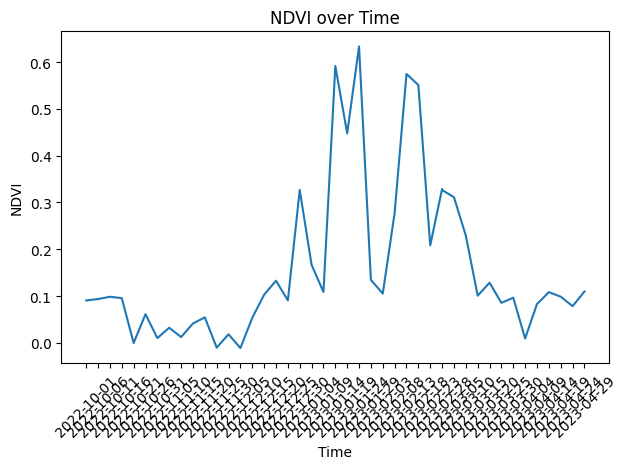

In [133]:

import ee
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Datas de análise
start_date = '2022-10-01'
end_date = '2023-04-30'

# Instantiate the Sentinel2 class
sentinel = Sentinel2(vertices, start_date, end_date)

# Extract values to DataFrame
df_index = sentinel.extract_values()

df_index['percent'] = (df_index['cloud_free_area']/10000)/ df_index['polygon_area']

df_index['area_free_cloud'] = df_index['cloud_free_area']/10000

#df_index = df_index.drop(df_index[df_index['percent'] <= 0.6].index)

from scipy.signal import medfilt


# Apply median filter
#df_index['Filtered_Value'] = medfilt(df_index['NDVI'], kernel_size=6)

# Plot the NDVI values over time
plt.plot(df_index['time'], df_index['NDVI'])
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.title('NDVI over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [127]:
df_index

,EVI,NDVI,SATELLITE,cloud_free_area,image_id,polygon_area,time,percent,area_free_cloud
0,2.743494,0.090528,Sentinel-2,1.307320e+08,20221001T132229_20221001T132456_T23LLF,37205.42924,2022-10-01,0.351379,13073.195294
1,2.744289,0.093569,Sentinel-2,1.344802e+08,20221006T132241_20221006T132240_T23LLF,37205.42924,2022-10-06,0.361453,13448.019882
2,2.757106,0.098402,Sentinel-2,1.393232e+08,20221011T132229_20221011T132231_T23LLF,37205.42924,2022-10-11,0.374470,13932.315529
3,2.731226,0.095422,Sentinel-2,1.440689e+08,20221016T132241_20221016T132236_T23LLF,37205.42924,2022-10-16,0.387225,14406.888353
4,2.504631,-0.000497,Sentinel-2,1.823473e+08,20221021T132229_20221021T132232_T23LLF,37205.42924,2022-10-21,0.490109,18234.728824
5,2.725387,0.061143,Sentinel-2,1.400633e+08,20221026T132241_20221026T132236_T23LLF,37205.42924,2022-10-26,0.376459,14006.327647
6,2.472827,0.010051,Sentinel-2,3.761419e+08,20221031T132229_20221031T132231_T23LLF,37205.42924,2022-10-31,1.010987,37614.194118
7,-7.571932,0.032241,Sentinel-2,2.029837e+08,20221105T132241_20221105T132237_T23LLF,37205.42924,2022-11-05,0.545575,20298.366353
8,2.897067,0.012200,Sentinel-2,1.164818e+08,20221110T132229_20221110T132232_T23LLF,37205.42924,2022-11-10,0.313078,11648.184353
9,8.160782,0.041273,Sentinel-2,1.868148e+08,20221115T132241_20221115T132249_T23LLF,37205.42924,2022-11-15,0.502117,18681.480353


In [70]:
import ee
import pandas as pd

class Landsat:
    def __init__(self, polygon, start_date, end_date):
        self.polygon = ee.Geometry.Polygon(polygon)
        self.start_date = start_date
        self.end_date = end_date
        self.polygon_area = ee.Number(self.polygon.area())

    @staticmethod
    def add_ndvi(image):
        ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    @staticmethod
    def add_evi(image):
        evi = image.expression(
            '2.5 * (((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE)) + 1)',
            {
                'NIR': image.select('B5'),
                'RED': image.select('B4'),
                'BLUE': image.select('B2')
            }
        ).rename('EVI')
        return image.addBands(evi)

    @staticmethod
    def mask_clouds(image):
        qa = image.select('BQA')
        cloud_bit_mask = ee.Number(2).pow(4).int()
        shadow_bit_mask = ee.Number(2).pow(8).int()
        mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
            qa.bitwiseAnd(shadow_bit_mask).eq(0))
        return image.updateMask(mask)

    def extract_values(self):
        collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
            .filterDate(self.start_date, self.end_date) \
            .filterBounds(self.polygon) \
            .map(self.mask_clouds) \
            .map(self.add_ndvi) \
            .map(self.add_evi)

        def extract(image):
            stats = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=self.polygon,
                scale=30,
                maxPixels=1e9
            )
            ndvi = stats.get('NDVI')
            evi = stats.get('EVI')
            time = image.get('system:time_start')
            image_id = image.get('system:index')

            # Create a mask for cloud-free pixels
            cloud_mask = image.select('BQA').bitwiseAnd(1 << 4).eq(0).And(
                image.select('BQA').bitwiseAnd(1 << 8).eq(0)
            )
            cloud_free_image = image.updateMask(cloud_mask)
            
            cloud_free_area = cloud_free_image.reduceRegion(
                reducer=ee.Reducer.count(),
                geometry=self.polygon,
                scale=30,
                maxPixels=1e9
            ).get('B5')  # Using B5 just to get the pixel count

            cloud_free_area = ee.Number(cloud_free_area).multiply(900)  # Convert pixel count to area (30m * 30m per pixel)

            return ee.Feature(None, {
                'time': ee.Date(time).format('YYYY-MM-dd'),
                'NDVI': ndvi,
                'EVI': evi,
                'SATELLITE': 'Landsat-8',
                'image_id': image_id,
                'cloud_free_area': cloud_free_area,  # Area with cloud mask applied within the polygon
                'polygon_area': self.polygon_area  # Total polygon area
            })

        # Map the extract function over the collection
        features = collection.map(extract).getInfo()['features']
        data = [f['properties'] for f in features]
        df = pd.DataFrame(data)
        
        # Ensure 'cloud_free_area' and 'polygon_area' columns are present
        if 'cloud_free_area' in df.columns:
            df['cloud_free_area'] = df['cloud_free_area'].astype(float)  # Convert to float for calculations
        else:
            df['cloud_free_area'] = 0.0  # Assign 0 if the column is missing

        if 'polygon_area' in df.columns:
            df['polygon_area'] = df['polygon_area'].astype(float)  # Convert to float for calculations
        else:
            df['polygon_area'] = self.polygon_area.getInfo()  # Assign the pre-calculated polygon area

        return df

import ee
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Define the polygon and date range (example values)
polygon = [[
    [-122.275, 37.871],
    [-122.275, 37.869],
    [-122.273, 37.869],
    [-122.273, 37.871]
]]
start_date = '2022-01-01'
end_date = '2022-12-31'

# Instantiate the Landsat class
landsat = Landsat(polygon, start_date, end_date)

# Extract values to DataFrame
df_index = landsat.extract_values()

# Plot the NDVI values over time
plt.plot(df_index['time'], df_index['NDVI'])
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.title('NDVI over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



KeyError: 'time'

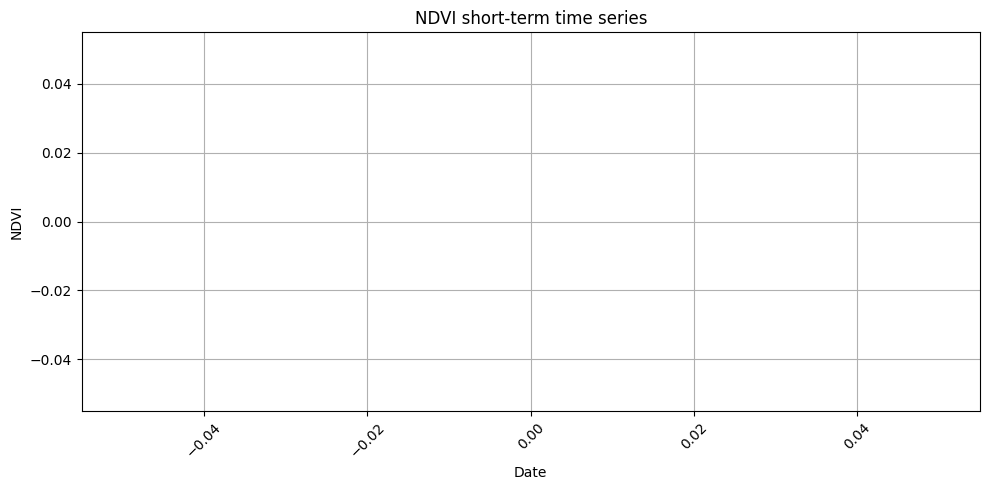

In [137]:
import ee
import geemap
import matplotlib.pyplot as plt



# Define the region of interest (Somaliland)
geometry = ee.Geometry.Polygon(vertices)

# Create image collection of Sentinel-2 imagery for the period 2016-2018
S2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate( start_date, end_date) \
    .filterBounds(geometry)

# Function to mask clouds using the QA60 band
def mask_clouds(image):
    qa60 = image.select('QA60')
    return image.updateMask(qa60.lt(1))

# Function to calculate and add an NDVI band
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Apply cloud mask and NDVI calculation
S2 = S2.map(mask_clouds).map(add_ndvi)

# Extract NDVI band and create NDVI median composite image
ndvi = S2.select('NDVI')
ndvi_med = ndvi.median()

# Create a palette for NDVI visualization
ndvi_palette = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a']

# Display NDVI median composite on the map
Map = geemap.Map()
Map.centerObject(geometry, 8)
Map.addLayer(ndvi_med.clip(geometry), {'min': -0.5, 'max': 0.9, 'palette': ndvi_palette}, 'NDVI')
Map.addLayerControl()
Map

# Create a time series chart
def get_time_series(feature_collection, roi, band_name, scale, start_date, end_date):
    def reduce_region(image):
        stat = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=scale,
            maxPixels=1e9
        )
        date = image.date().format('YYYY-MM-dd')
        return ee.Feature(None, {'date': date, 'mean': stat.get(band_name)})

    filtered = feature_collection.filterDate(start_date, end_date)
    stats = filtered.map(reduce_region).filter(ee.Filter.notNull(['mean']))
    return stats

ndvi_stats = get_time_series(S2, geometry, 'NDVI', 500, '2018-09-01', '2018-10-31').getInfo()

# Extract dates and NDVI values
dates = [feature['properties']['date'] for feature in ndvi_stats['features']]
ndvi_values = [feature['properties']['mean'] for feature in ndvi_stats['features']]

# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(dates, ndvi_values, marker='o', linestyle='-')
plt.title('NDVI short-term time series')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df_index

,EVI,NDVI,SATELLITE,cloud_free_area,image_id,polygon_area,time,cloud
2,2.904516,0.277178,Sentinel-2,38901.176471,20220109T185749_20220109T185743_T10SEG,39041.916402,2022-01-09,0.996395
3,3.990935,0.280756,Sentinel-2,38901.176471,20220109T185749_20220109T185743_T10SEH,39041.916402,2022-01-09,0.996395
4,3.349015,0.284386,Sentinel-2,38901.176471,20220114T185731_20220114T185853_T10SEG,39041.916402,2022-01-14,0.996395
5,3.330682,0.282315,Sentinel-2,38901.176471,20220114T185731_20220114T185853_T10SEH,39041.916402,2022-01-14,0.996395
6,1.515371,0.094435,Sentinel-2,38901.176471,20220119T185709_20220119T185710_T10SEG,39041.916402,2022-01-19,0.996395
...,...,...,...,...,...,...,...,...
141,1.693664,0.076502,Sentinel-2,38901.176471,20221220T185811_20221220T185808_T10SEH,39041.916402,2022-12-20,0.996395
142,1.866594,0.079373,Sentinel-2,38901.176471,20221225T185809_20221225T190037_T10SEG,39041.916402,2022-12-25,0.996395
143,1.870853,0.076502,Sentinel-2,38901.176471,20221225T185809_20221225T190037_T10SEH,39041.916402,2022-12-25,0.996395
144,2.476567,0.009199,Sentinel-2,38901.176471,20221230T185811_20221230T185805_T10SEG,39041.916402,2022-12-30,0.996395
